# A Empresa Cardio Catch Diseases ( CCD )

### Informações da base de dados

- Age: Idade em dias
- Height: Altura em centímetros
- Weight: Peso em quilogramas
- Gender: Gênero (1 - mulheres, 2 - homens)
- ap_hi: Pressão arterial sistólica (é aquela que marca a contração do músculo cardíaco, quando ele bombeia sangue para o corpo) 
         Normal: <130, Normal alta: 130-139, Hipertensão de grau 1: 140-159, Hipertensão de grau 2: ≥160

- ap_lo: Pressão arterial diastólica (é a do momento de repouso, em que os vasos permanecem abertos para o sangue passar)
         Normal: <85, Normal alta: 85-89, Hipertensão de grau 1: 90-99, Hipertensão de grau 2: ≥100

- Cholesterol: Colesterol (1 - normal, 2 - acima do normal, 3 - bem acima do normal)
- gluc: Glicose (1 - normal, 2 - acima do normal, 3 - bem acima do normal)
- smoke: Fumante (0 - não, 1 - sim)
- alco: Ingestão de álcool (0 - não, 1 - sim)
- active: Atividade física (0 - não, 1 - sim)
- cardio: Presença ou ausência de doença cardiovascular (0 - não, 1 - sim)

## - Objetivo: criar uma ferramenta que aumente a precisão do diagnóstico e que essa precisão seja estável para todos os diagnósticos.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

In [3]:
sns.set_style('darkgrid')

In [4]:
dados = pd.read_csv("cardio_train.csv", sep = ";")

In [5]:
dados.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [6]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


A base de dados não possui valores faltantes.

### - Análise inicial

#### - Coluna de identificação

In [7]:
len(np.unique(dados.id))

70000

- Não temos identificações repetidas

#### - Variáveis categóricas

In [8]:
print(f"valores das variáveis:\ncholesterol:{np.unique(dados.cholesterol)},\ngluc: {np.unique(dados.gluc)},\n\
smoke: {np.unique(dados.smoke)},\nalco: {np.unique(dados.alco)},\nactive: {np.unique(dados.active)},\n\
cardio: {np.unique(dados.cardio)}\ngender: {np.unique(dados.gender)}")

valores das variáveis:
cholesterol:[1 2 3],
gluc: [1 2 3],
smoke: [0 1],
alco: [0 1],
active: [0 1],
cardio: [0 1]
gender: [1 2]


- As variáveis categóricas não possuem valores fora do esperado.

#### - Variáveis quantitativas

In [9]:
dados['age_year'] = round(dados['age']/365)
print(f"As idades informadas estão entre {min(dados['age_year'])} e {max(dados['age_year'])} anos.")

As idades informadas estão entre 30.0 e 65.0 anos.


In [10]:
print(f'Peso mais baixo: {min(dados.weight)}, maior peso: {max(dados.weight)}')
print(f'Menor altura: {min(dados.height)}, maior altura: {max(dados.height)}')

Peso mais baixo: 10.0, maior peso: 200.0
Menor altura: 55, maior altura: 250


- Para facilitar a utilização desses dados na predição o índice de massa corporal.

In [11]:
dados['imc'] = dados.weight/(dados.height/100)**2

In [12]:
print(f"Pressão arterial sistólica mais baixa {min(dados['ap_hi'])} e mais alta {max(dados['ap_hi'])}.")

Pressão arterial sistólica mais baixa -150 e mais alta 16020.


In [13]:
print(f"Pressão arterial diastólica mais baixa {min(dados['ap_lo'])} e mais alta {max(dados['ap_lo'])}.")

Pressão arterial diastólica mais baixa -70 e mais alta 11000.


- Como temos alguns valores que parecem destoar da realidade, vamos criar categorizar as variáveis de forma que o classificador tenha sucesso na hora da predição.

In [14]:
dados.loc[(dados.ap_hi < 130), 'cat_aphi'] = 'normal'
dados.loc[(dados.ap_hi >= 130) & (dados.ap_hi < 140), 'cat_aphi'] = 'normal alto'
dados.loc[(dados.ap_hi >= 140) & (dados.ap_hi < 159), 'cat_aphi'] = 'Hipertensão de grau 1'
dados.loc[(dados.ap_hi >= 160), 'cat_aphi'] = 'Hipertensão de grau 2'

In [15]:
dados.loc[(dados.ap_lo < 85), 'cat_aplo'] = 'normal'
dados.loc[(dados.ap_lo >= 85) & (dados.ap_lo < 90), 'cat_aplo'] = 'normal alto'
dados.loc[(dados.ap_lo >= 90) & (dados.ap_lo < 99), 'cat_aplo'] = 'Hipertensão de grau 1'
dados.loc[(dados.ap_lo >= 100), 'cat_aplo'] = 'Hipertensão de grau 2'

In [16]:
dados.imc = pd.to_numeric(dados.imc)
dados.loc[(dados.imc < 16), 'cat_imc'] = 'subpeso severo'
dados.loc[(dados.imc >= 16) & (dados.imc < 20), 'cat_imc'] = 'subpeso'
dados.loc[(dados.imc >= 20) & (dados.imc < 25), 'cat_imc'] = 'normal'
dados.loc[(dados.imc >= 25) & (dados.imc < 30), 'cat_imc'] = 'sobrepeso'
dados.loc[(dados.imc >= 30) & (dados.imc < 40), 'cat_imc'] = 'obesidade'
dados.loc[(dados.imc >= 40), 'cat_imc'] = 'obesidade mórbida'

In [17]:
dados.loc[(dados.age_year >= 30) & (dados.age_year < 40), 'cat_age'] = '[30, 40)'
dados.loc[(dados.age_year >= 40) & (dados.age_year < 50), 'cat_age'] = '[40, 50)'
dados.loc[(dados.age_year >= 50) & (dados.age_year < 60), 'cat_age'] = '[50, 60)'
dados.loc[(dados.age_year >= 60) & (dados.age_year <= 65), 'cat_age'] = '[60, 65]'

In [18]:
dados.gender = dados.gender.replace([1, 2], ['M', 'H'])

In [19]:
dados.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_year,imc,cat_aphi,cat_aplo,cat_imc,cat_age
0,0,18393,H,168,62.0,110,80,1,1,0,0,1,0,50.0,21.967120,normal,normal,normal,"[50, 60)"
1,1,20228,M,156,85.0,140,90,3,1,0,0,1,1,55.0,34.927679,Hipertensão de grau 1,Hipertensão de grau 1,obesidade,"[50, 60)"
2,2,18857,M,165,64.0,130,70,3,1,0,0,0,1,52.0,23.507805,normal alto,normal,normal,"[50, 60)"
3,3,17623,H,169,82.0,150,100,1,1,0,0,1,1,48.0,28.710479,Hipertensão de grau 1,Hipertensão de grau 2,sobrepeso,"[40, 50)"
4,4,17474,M,156,56.0,100,60,1,1,0,0,0,0,48.0,23.011177,normal,normal,normal,"[40, 50)"


In [20]:
data_to_predict = dados[['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'cat_aphi', 'cat_aplo', 'cat_imc', 'cat_age', 'active', 'cardio']]

## - Análise Visual

In [21]:
data_to_predict.head()

,gender,cholesterol,gluc,smoke,alco,cat_aphi,cat_aplo,cat_imc,cat_age,active,cardio
0,H,1,1,0,0,normal,normal,normal,"[50, 60)",1,0
1,M,3,1,0,0,Hipertensão de grau 1,Hipertensão de grau 1,obesidade,"[50, 60)",1,1
2,M,3,1,0,0,normal alto,normal,normal,"[50, 60)",0,1
3,H,1,1,0,0,Hipertensão de grau 1,Hipertensão de grau 2,sobrepeso,"[40, 50)",1,1
4,M,1,1,0,0,normal,normal,normal,"[40, 50)",0,0


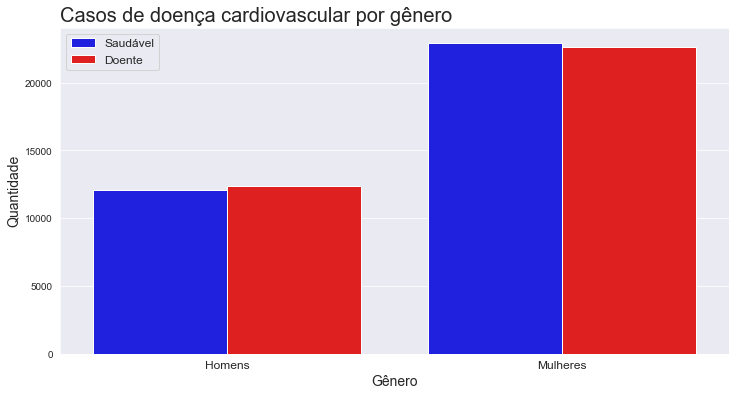

In [22]:
plt.figure(figsize = (12, 6))
genero = sns.countplot(x = 'gender', hue = 'cardio', data = data_to_predict, palette = ['blue', 'red'])
genero.set_title("Casos de doença cardiovascular por gênero", fontsize = 20, loc = 'left')
genero.set_xlabel("Gênero", fontsize = 14)
genero.set_ylabel("Quantidade", fontsize = 14)
genero.legend(['Saudável', 'Doente'], fontsize = 12)
genero.set_xticklabels(['Homens', 'Mulheres'], fontsize = 12)
genero = genero

- A proporção de doença cardiovascular é muito semelhante entre homens e mulheres. 

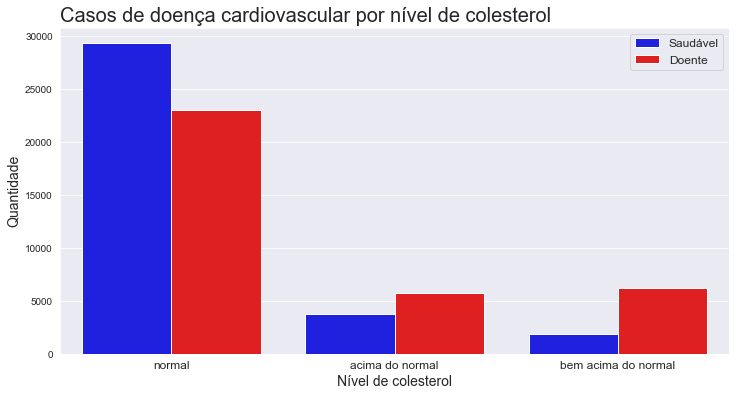

In [23]:
plt.figure(figsize = (12, 6))
col = sns.countplot(x = 'cholesterol', hue = 'cardio', data = data_to_predict, palette = ['blue', 'red'])
col.set_title("Casos de doença cardiovascular por nível de colesterol", fontsize = 20, loc = 'left')
col.set_xlabel("Nível de colesterol", fontsize = 14)
col.set_ylabel("Quantidade", fontsize = 14)
col.legend(['Saudável', 'Doente'], fontsize = 12)
col.set_xticklabels(['normal', 'acima do normal', 'bem acima do normal'], fontsize = 12)
col = col

- Quanto maior o nível de colesterol maior a proporção de incidência de doença cardiovascular.

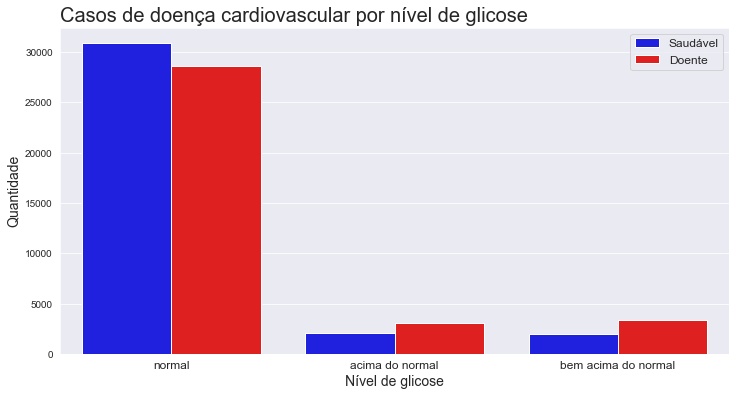

In [24]:
plt.figure(figsize = (12, 6))
gli = sns.countplot(x = 'gluc', hue = 'cardio', data = data_to_predict, palette = ['blue', 'red'])
gli.set_title("Casos de doença cardiovascular por nível de glicose", fontsize = 20, loc = 'left')
gli.set_xlabel("Nível de glicose", fontsize = 14)
gli.set_ylabel("Quantidade", fontsize = 14)
gli.legend(['Saudável', 'Doente'], fontsize = 12)
gli.set_xticklabels(['normal', 'acima do normal', 'bem acima do normal'], fontsize = 12)
gli = gli

- A proporção de doença cardiovascular aumenta com o aumento do nível de glicose.

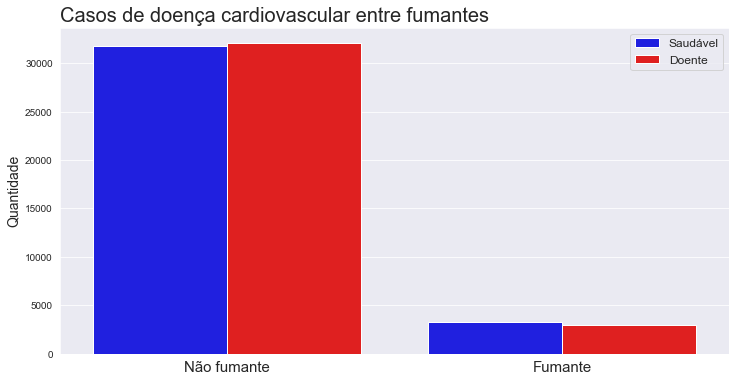

In [25]:
plt.figure(figsize = (12, 6))
fumo = sns.countplot(x = 'smoke', hue = 'cardio', data = data_to_predict, palette = ['blue', 'red'])
fumo.set_title("Casos de doença cardiovascular entre fumantes", fontsize = 20, loc = 'left')
fumo.set_xlabel("")
fumo.set_ylabel("Quantidade", fontsize = 14)
fumo.legend(['Saudável', 'Doente'], fontsize = 12)
fumo.set_xticklabels(['Não fumante', 'Fumante'], fontsize = 15)
fumo = fumo

- A proporção de doença cardiovascular parece não ser afetada significativamente pelo consumo de cigarros.

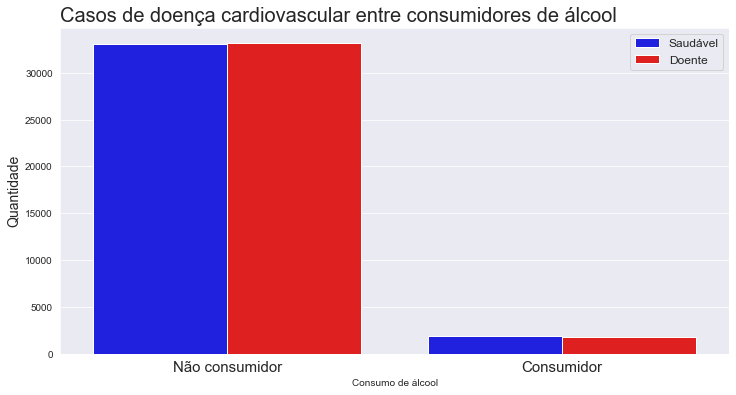

In [26]:
plt.figure(figsize = (12, 6))
alc = sns.countplot(x = 'alco', hue = 'cardio', data = data_to_predict, palette = ['blue', 'red'])
alc.set_title("Casos de doença cardiovascular entre consumidores de álcool", fontsize = 20, loc = 'left')
alc.set_xlabel("Consumo de álcool")
alc.set_ylabel("Quantidade", fontsize = 14)
alc.legend(['Saudável', 'Doente'], fontsize = 12)
alc.set_xticklabels(['Não consumidor', 'Consumidor'], fontsize = 15)
alc = alc

- O consumo de álcool não influência na ocorrência de doença cardiovascular.

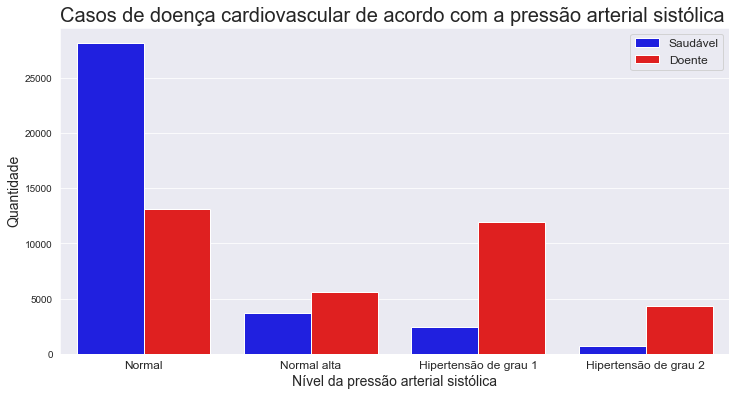

In [27]:
plt.figure(figsize = (12, 6))
sist = sns.countplot(x = 'cat_aphi', hue = 'cardio', data = data_to_predict, palette = ['blue', 'red'],
                      order = ['normal', 'normal alto', 'Hipertensão de grau 1', 'Hipertensão de grau 2'])
sist.set_title("Casos de doença cardiovascular de acordo com a pressão arterial sistólica", fontsize = 20, loc = 'left')
sist.set_xlabel("Nível da pressão arterial sistólica", fontsize = 14)
sist.set_ylabel("Quantidade", fontsize = 14)
sist.legend(['Saudável', 'Doente'], fontsize = 12)
sist.set_xticklabels(['Normal', 'Normal alta', 'Hipertensão de grau 1', 'Hipertensão de grau 2'], fontsize = 12)
sist = sist

- A proporção da doença aumenta significativamente com o aumento da pressão arterial sistólica. O nível de hipertensão de grau 1 parece ser o grau de pressão que mais afeta a causa da doença.

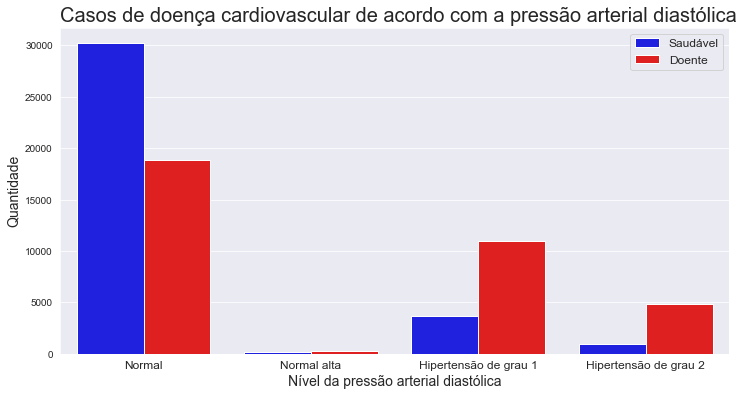

In [28]:
plt.figure(figsize = (12, 6))
dias = sns.countplot(x = 'cat_aplo', hue = 'cardio', data = data_to_predict, palette = ['blue', 'red'],
                       order = ['normal', 'normal alto', 'Hipertensão de grau 1', 'Hipertensão de grau 2'])
dias.set_title("Casos de doença cardiovascular de acordo com a pressão arterial diastólica", fontsize = 20, loc = 'left')
dias.set_xlabel("Nível da pressão arterial diastólica", fontsize = 14)
dias.set_ylabel("Quantidade", fontsize = 14)
dias.legend(['Saudável', 'Doente'], fontsize = 12)
dias.set_xticklabels(['Normal', 'Normal alta', 'Hipertensão de grau 1', 'Hipertensão de grau 2'], fontsize = 12)
dias = dias

- Assim como a pressão arterial sistólica, a pressão arterial diastélica também afeta a ocorrência de doença cardiovascular.

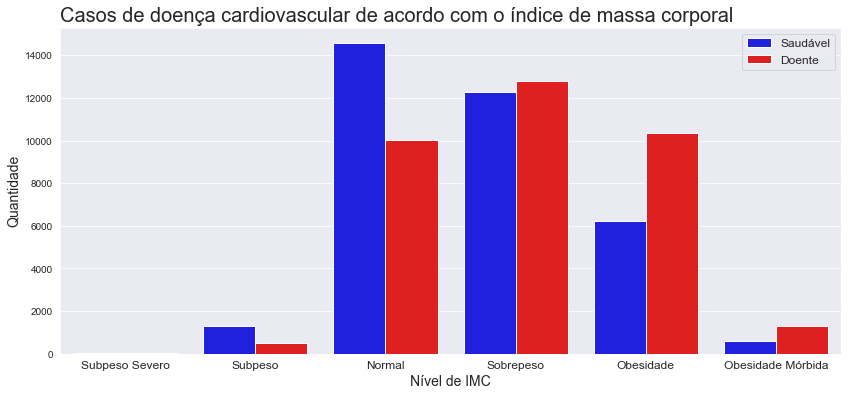

In [29]:
plt.figure(figsize = (14, 6))
imc = sns.countplot(x = 'cat_imc', hue = 'cardio', data = data_to_predict, palette = ['blue', 'red'],
                      order = ['subpeso severo', 'subpeso', 'normal', 'sobrepeso', 'obesidade', 'obesidade mórbida'])
imc.set_title("Casos de doença cardiovascular de acordo com o índice de massa corporal", fontsize = 20, loc = 'left')
imc.set_xlabel("Nível de IMC", fontsize = 14)
imc.set_ylabel("Quantidade", fontsize = 14)
imc.legend(['Saudável', 'Doente'], fontsize = 12)
imc.set_xticklabels(['Subpeso Severo', 'Subpeso', 'Normal', 'Sobrepeso', 'Obesidade', 'Obesidade Mórbida'], fontsize = 12)
imc = imc

- Aqui também é fácil perceber que o aumento do índice de massa corporal influencia na proporção da incidência de doença cardiovascular, principalmente no nível de obesidade.

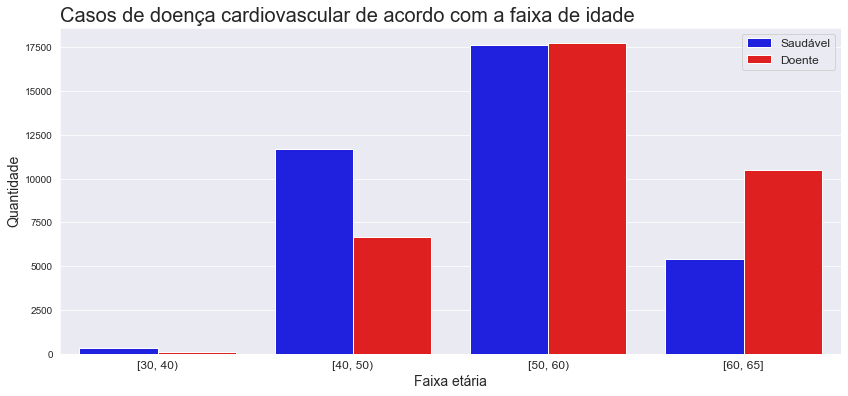

In [30]:
plt.figure(figsize = (14, 6))
idade = sns.countplot(x = 'cat_age', hue = 'cardio', data = data_to_predict, palette = ['blue', 'red'],
                       order = ['[30, 40)', '[40, 50)', '[50, 60)', '[60, 65]'])
idade.set_title("Casos de doença cardiovascular de acordo com a faixa de idade", fontsize = 20, loc = 'left')
idade.set_xlabel("Faixa etária", fontsize = 14)
idade.set_ylabel("Quantidade", fontsize = 14)
idade.legend(['Saudável', 'Doente'], fontsize = 12)
idade.set_xticklabels(['[30, 40)', '[40, 50)', '[50, 60)', '[60, 65]'], fontsize = 12)
idade = idade

- O risco de doença cardiovascular aumenta de acordo com a faixa etária, sendo muito mais incidênte após os 60 anos de idade.

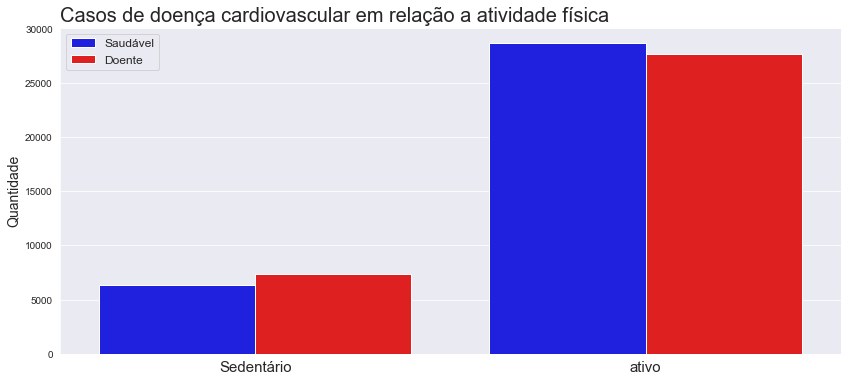

In [31]:
plt.figure(figsize = (14, 6))
ativ = sns.countplot(x = 'active', hue = 'cardio', data = data_to_predict, palette = ['blue', 'red'])
ativ.set_title("Casos de doença cardiovascular em relação a atividade física", fontsize = 20, loc = 'left')
ativ.set_xlabel("")
ativ.set_ylabel("Quantidade", fontsize = 14)
ativ.legend(['Saudável', 'Doente'], fontsize = 12)
ativ.set_xticklabels(['Sedentário', 'ativo'], fontsize = 15)
ativ = ativ

- Atividade física parece influenciar muito pouco na proporção de incidência de doença cardiovascular.

- Pela análise visual vimos que as variáveis que mais influênciam na proporção de incidência de doença cardiovascular são:
>Colesterol (cholesterol)\
 Glicose (gluc)\
 Pressão arterial sistólica (cat_aphi)\
 Pressão arterial diastólica (cat_aplo)\
 Índice de massa corporal (cat_imc)\
 Faixa de idade (cat_age)

## - Teste de Hipótese Qui-Quadrado de Pearson

- Com a finalidade de confirmar a realação entre as variáveis vamos aplicar o teste qui-quadrado de pearson considerando com nível de confiança de 95%. As hipóteses nula e alternativa são:

> $H_0:$ as duas variáveis categóricas se associam de forma aleatória;\
> $H_1:$  as duas variáveis categóricas não se associam de forma aleatória.

In [32]:
tab_gender = pd.crosstab(data_to_predict.gender, data_to_predict.cardio)
tab_chol = pd.crosstab(data_to_predict.cholesterol, data_to_predict.cardio)
tab_gluc = pd.crosstab(data_to_predict.gluc, data_to_predict.cardio)
tab_smoke = pd.crosstab(data_to_predict.smoke, data_to_predict.cardio)
tab_alco = pd.crosstab(data_to_predict.alco, data_to_predict.cardio)
tab_aphi = pd.crosstab(data_to_predict.cat_aphi, data_to_predict.cardio)
tab_aplo = pd.crosstab(data_to_predict.cat_aplo, data_to_predict.cardio)
tab_imc = pd.crosstab(data_to_predict.cat_imc, data_to_predict.cardio)
tab_age = pd.crosstab(data_to_predict.cat_age, data_to_predict.cardio)
tab_active = pd.crosstab(data_to_predict.active, data_to_predict.cardio)

In [33]:
_, p_gender, _, _ = chi2_contingency(tab_gender)
_, p_chol, _, _ = chi2_contingency(tab_chol)
_, p_gluc, _, _ = chi2_contingency(tab_gluc)
_, p_smoke, _, _ = chi2_contingency(tab_smoke)
_, p_alco, _, _ = chi2_contingency(tab_alco)
_, p_aphi, _, _ = chi2_contingency(tab_aphi)
_, p_aplo, _, _ = chi2_contingency(tab_aplo)
_, p_imc, _, _ = chi2_contingency(tab_imc)
_, p_age, _, _ = chi2_contingency(tab_age)
_, p_active, _, _ = chi2_contingency(tab_active)

In [34]:
print("Resultado do p-valor para cada variável comparada com a ocorrência de doença cardio vascular:")
print(" - Genero:", round(p_gender, 4))
print(" - Colesterol:", round(p_chol, 4))
print(" - Glicose:", round(p_gluc, 4))
print(" - Fumante:", round(p_smoke, 4))
print(" - Ingestão de ácool:", round(p_alco, 4))
print(" - Pressão arterial sistólica:", round(p_aphi, 4))
print(" - Pressão arterial diastólica:", round(p_aplo, 4))
print(" - Indice de massa corporal:", round(p_imc, 4))
print(" - Idade:", round(p_age, 4))
print(" - Atividade física:", round(p_active, 4))

Resultado do p-valor para cada variável comparada com a ocorrência de doença cardio vascular:
 - Genero: 0.0325
 - Colesterol: 0.0
 - Glicose: 0.0
 - Fumante: 0.0
 - Ingestão de ácool: 0.0545
 - Pressão arterial sistólica: 0.0
 - Pressão arterial diastólica: 0.0
 - Indice de massa corporal: 0.0
 - Idade: 0.0
 - Atividade física: 0.0


> Ao nível de confiança de 95%, para rejeitarmos a hipótese nula ($H_0$), precisamos de um p-valor(porcentagem de cauda) menor que 0,05. Portanto, das variáveis acima a única que deve ser eliminada do modelo, ou seja, que se associa aleatóriamente com doença cardiovascular, é a ingestão de álcool.

## - Preparando o modelo de classificação

- Preparando a classificação

In [35]:
data_to_predict.head()

,gender,cholesterol,gluc,smoke,alco,cat_aphi,cat_aplo,cat_imc,cat_age,active,cardio
0,H,1,1,0,0,normal,normal,normal,"[50, 60)",1,0
1,M,3,1,0,0,Hipertensão de grau 1,Hipertensão de grau 1,obesidade,"[50, 60)",1,1
2,M,3,1,0,0,normal alto,normal,normal,"[50, 60)",0,1
3,H,1,1,0,0,Hipertensão de grau 1,Hipertensão de grau 2,sobrepeso,"[40, 50)",1,1
4,M,1,1,0,0,normal,normal,normal,"[40, 50)",0,0


In [36]:
x = data_to_predict[["gender", "cholesterol", "gluc", "smoke", "cat_aphi", "cat_aplo", "cat_imc", "cat_age", "active"]]
y = data_to_predict[["cardio"]]
print(x.shape, y.shape)

(70000, 9) (70000, 1)


In [37]:
x.head()

,gender,cholesterol,gluc,smoke,cat_aphi,cat_aplo,cat_imc,cat_age,active
0,H,1,1,0,normal,normal,normal,"[50, 60)",1
1,M,3,1,0,Hipertensão de grau 1,Hipertensão de grau 1,obesidade,"[50, 60)",1
2,M,3,1,0,normal alto,normal,normal,"[50, 60)",0
3,H,1,1,0,Hipertensão de grau 1,Hipertensão de grau 2,sobrepeso,"[40, 50)",1
4,M,1,1,0,normal,normal,normal,"[40, 50)",0


In [38]:
x = pd.get_dummies(x, columns = ["gender", "cholesterol", "gluc", "cat_aphi", "cat_aplo", "cat_imc", "cat_age"])

In [39]:
x.head()

,smoke,active,gender_H,gender_M,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3,...,cat_imc_normal,cat_imc_obesidade,cat_imc_obesidade mórbida,cat_imc_sobrepeso,cat_imc_subpeso,cat_imc_subpeso severo,"cat_age_[30, 40)","cat_age_[40, 50)","cat_age_[50, 60)","cat_age_[60, 65]"
0,0,1,1,0,1,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
1,0,1,0,1,0,0,1,1,0,0,...,0,1,0,0,0,0,0,0,1,0
2,0,0,0,1,0,0,1,1,0,0,...,1,0,0,0,0,0,0,0,1,0
3,0,1,1,0,1,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
4,0,0,0,1,1,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0


>Para classificarmos os dados vamos utilizar o algoritmo árvore de decisão, porém não queremos usar apenas uma árvore para nosso dados. Portanto, testaremos dois algoritmos, RandomForestClassifier (adiciona variabilidade nos dados) e ExtraTreeClassifier (adiciona variabilidade nos classificadores).

## - Otimização de Hiperparâmetros

In [40]:
espaco_parametros = {
    "n_estimators" : randint(10, 50),
    "max_depth" : randint(1, 5),
    "bootstrap" : [True, False],
    "criterion": ["entropy"]
}


### - Random Forest Classifier

In [41]:
modelo_rtc = RandomizedSearchCV(estimator = RandomForestClassifier(),
                                param_distributions = espaco_parametros,
                                n_iter = 10,
                                cv = KFold(n_splits = 10, shuffle = True),
                                random_state = 827
                                )
modelo_rtc.fit(x, y)

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
                   estimator=RandomForestClassifier(),
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['entropy'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000022ED39B66D0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000022ED3EECC40>},
                   random_state=827)

In [42]:
modelo_rtc.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=4, n_estimators=25)

In [43]:
resultado_rtc = pd.DataFrame(modelo_rtc.cv_results_)

In [44]:
resultado_rtc[max(modelo_rtc.cv_results_["mean_test_score"]) == modelo_rtc.cv_results_["mean_test_score"]]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_n_estimators,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
6,0.50926,0.012493,0.017175,0.004691,True,entropy,4,25,"{'bootstrap': True, 'criterion': 'entropy', 'm...",0.736286,...,0.728143,0.727,0.719714,0.718286,0.724,0.724429,0.726286,0.724943,0.004907,1


In [45]:
scores_rtc = cross_val_score(modelo_rtc, x, y, cv = KFold(n_splits = 10, shuffle = True))

In [56]:
media_rtc = scores_rtc.mean()
desvio_padrao_rtc = scores_rtc.std()

### - Extra Tree Classifier

In [47]:
modelo_etc = RandomizedSearchCV(estimator = ExtraTreesClassifier(),
                                param_distributions = espaco_parametros,
                                n_iter = 50,
                                cv = KFold(n_splits = 10, shuffle = True),
                                random_state = 827
                                )
modelo_etc.fit(x, y)

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
                   estimator=ExtraTreesClassifier(), n_iter=50,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['entropy'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000022ED39B66D0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000022ED3EECC40>},
                   random_state=827)

In [48]:
modelo_etc.best_estimator_

ExtraTreesClassifier(criterion='entropy', max_depth=4, n_estimators=45)

In [49]:
resultado_etc = pd.DataFrame(modelo_etc.cv_results_)

In [50]:
resultado_etc[max(modelo_etc.cv_results_["mean_test_score"]) == modelo_etc.cv_results_["mean_test_score"]]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_n_estimators,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
47,0.862307,0.031868,0.031235,0.006977,False,entropy,4,45,"{'bootstrap': False, 'criterion': 'entropy', '...",0.723143,...,0.739429,0.730571,0.722714,0.724857,0.729429,0.723143,0.724429,0.726443,0.005063,1


In [51]:
scores_etc = cross_val_score(modelo_etc, x, y, cv = KFold(n_splits = 10, shuffle = True))

In [55]:
media_etc = scores_etc.mean()
desvio_padrao_etc = scores_etc.std()

In [60]:
print("Random Forest Classifier:")
print("Acurácia média = %.2f" % (media_rtc * 100))
print("Com intervalo = [%.2f, %.2f]" % ((media_rtc - 2 * desvio_padrao_rtc)*100, (media_rtc + 2 * desvio_padrao_rtc) * 100))

Random Forest Classifier:
Accurácia média = 72.58
Com intervalo = [71.38, 73.79]


In [58]:
print("Extra Tree Classifier")
print("Acurácia média = %.2f" % (media_etc * 100))
print("Com intervalo = [%.2f, %.2f]" % ((media_etc - 2 * desvio_padrao_etc)*100, (media_etc + 2 * desvio_padrao_etc) * 100))

Extra Tree Classifier
Acurácia média = 72.66
Com intervalo = [71.40, 73.92]


> Os dois modelos tiveram o mesmo resultado. Vamos escolher a RandomForestClassifier por este algoritmo ter utilizado menos estimadores.

## - Modelo Random Forest Classifier

In [164]:
modelo = RandomForestClassifier(criterion='entropy', max_depth=4, n_estimators=25, random_state = 827)
modelo.fit(x, y)

RandomForestClassifier(criterion='entropy', max_depth=4, n_estimators=25,
                       random_state=827)

In [123]:
x.columns

Index(['smoke', 'active', 'gender_H', 'gender_M', 'cholesterol_1',
       'cholesterol_2', 'cholesterol_3', 'gluc_1', 'gluc_2', 'gluc_3',
       'cat_aphi_Hipertensão de grau 1', 'cat_aphi_Hipertensão de grau 2',
       'cat_aphi_normal', 'cat_aphi_normal alto',
       'cat_aplo_Hipertensão de grau 1', 'cat_aplo_Hipertensão de grau 2',
       'cat_aplo_normal', 'cat_aplo_normal alto', 'cat_imc_normal',
       'cat_imc_obesidade', 'cat_imc_obesidade mórbida', 'cat_imc_sobrepeso',
       'cat_imc_subpeso', 'cat_imc_subpeso severo', 'cat_age_[30, 40)',
       'cat_age_[40, 50)', 'cat_age_[50, 60)', 'cat_age_[60, 65]'],
      dtype='object')

In [168]:
def cardio_diag(genero, colesterol, glicose, fumante, pre_art_sistolica, pre_art_diastolica, imc, idade, ativo):
    dados = pd.DataFrame(data= {
        'smoke':[0], 
        'active':[0], 
        'gender_H':[0], 'gender_M':[0], 
        'cholesterol_1':[0], 'cholesterol_2':[0], 'cholesterol_3':[0], 
        'gluc_1':[0], 'gluc_2':[0], 'gluc_3':[0], 
        'cat_aphi_Hipertensão de grau 1':[0], 'cat_aphi_Hipertensão de grau 2':[0], 'cat_aphi_normal':[0], 'cat_aphi_normal alto':[0],
        'cat_aplo_Hipertensão de grau 1':[0], 'cat_aplo_Hipertensão de grau 2':[0], 'cat_aplo_normal':[0], 'cat_aplo_normal alto':0, 'cat_imc_normal':[0],
        'cat_imc_obesidade':[0], 'cat_imc_obesidade mórbida':[0], 'cat_imc_sobrepeso':[0],
        'cat_imc_subpeso':[0], 'cat_imc_subpeso severo':[0], 
        'cat_age_[30, 40)':[0], 'cat_age_[40, 50)':[0], 'cat_age_[50, 60)':[0], 'cat_age_[60, 65]':[0]
    })

    #fumante
    dados.smoke = fumante
    #Atividade física
    dados.active = ativo
    
    #genero
    if genero.lower() == "h":
        dados.gender_H = 1
    elif genero.lower() == "m":
        dados.gender_M = 1

    #colesterol
    if colesterol == 1:
        dados.cholesterol_1 = 1
    elif colesterol == 2:
        dados.cholesterol_2 = 1 
    elif colesterol == 3:
        dados.cholesterol_3 = 1
    
    #glicose
    if glicose == 1:
        dados.glucl_1 = 1
    elif glicose == 2:
        dados.gluc_2 = 1 
    elif glicose == 3:
        dados.gluc_3 = 1
    
    #pressão sistólica
    if (pre_art_sistolica < 130):
        dados['cat_aphi_normal'] = 1
    elif (pre_art_sistolica >= 130) & (pre_art_sistolica < 140):
        dados['cat_aphi_normal alto'] = 1
    elif (pre_art_sistolica >= 140) & (pre_art_sistolica < 159):
        dados['cat_aphi_Hipertensão de grau 1'] = 1
    elif (dados.cat_aphi[0] >= 160):
        dados['cat_aphi_Hipertensão de grau 2'] = 1

    #pressão diastólica
    if (pre_art_diastolica < 85):
        dados['cat_aplo_normal'] = 1
    elif (pre_art_diastolica >= 85) & (pre_art_diastolica < 90):
        dados['cat_aplo_normal alto'] = 1
    elif (pre_art_diastolica >= 90) & (pre_art_diastolica < 99): 
        dados['cat_aplo_Hipertensão de grau 1'] = 1
    elif (pre_art_diastolica >= 100):
        dados['cat_aplo_Hipertensão de grau 2'] = 1
    
    
    #IMC
    if (imc < 16):
        dados['cat_imc_subpeso severo'] = 1
    elif (imc >= 16) & (imc < 20):
        dados['cat_imc_subpeso'] = 1
    elif (imc >= 20) & (imc < 25):
        dados['cat_imc_normal'] = 1
    elif (imc >= 25) & (imc < 30):
        dados['cat_imc_sobrepeso'] = 1
    elif (imc >= 30) & (imc < 40):
        dados['cat_imc_obesidade'] = 1
    elif (imc >= 40):
        dados['cat_imc_obesidade mórbida'] = 1
              
    #Idade
    if (idade >= 30) & (idade < 40):
        dados['cat_age_[30, 40)'] = 1
    elif (idade >= 40) & (idade < 50):
        dados['cat_age_[40, 50)'] = 1
    elif (idade >= 50) & (idade < 60):
        dados['cat_age_[50, 60)'] = 1
    elif (idade >= 60) & (idade <= 65):
        dados['cat_age_[60, 65]'] = 1
    
    predicao = modelo.predict(dados)
    if predicao[0] == 0:
        print("--------------------------------------------------------------")
        print("Não tem doença cardiovascular")
        print("Acurácia média do teste = 72.5, com intervalo = [71.38, 73.79]")
    elif predicao[0] == 1:
        print("--------------------------------------------------------------")
        print("Tem doença cardiovascular")
        print("Acurácia média do teste = 72.5, com intervalo = [71.38, 73.79]")

In [169]:
def diagnostico_cardiaco():    
    
    genero = str(input('Informe o gênero ("m" para mulher ou "h" para homem): '))    
    while (genero.lower() != "m" and genero.lower() != "h"):
        print('Você digitou errado!\nDigite "m" para mulher ou "h" para homem')
        genero = str(input('Informe o gênero ("m" para mulher ou "h" para homem): '))          
    
    colesterol = int(input('Informe nível colesterol (normal = 1, acima do normal = 2, bem acima do normal = 3): ')) 
    while (colesterol != 1 and colesterol != 2 and colesterol != 3):
        print('Você digitou errado!\nDigite 1 para "normal", 2 para "acima do normal", 3 para "bem acima do normal"')
        colesterol = int(input('Informe nível colesterol (normal = 1, acima do normal = 2, bem acima do normal = 3): '))
                     
    glicose = int(input('Informe nível de glicose (normal = 1, acima do normal = 2, bem acima do normal = 3): '))
    while (glicose != 1 and glicose != 2 and glicose != 3):
        print('Você digitou errado!\nDigite 1 para "normal", 2 para "acima do normal", 3 para "bem acima do normal"')
        glicose = int(input('Informe nível de glicose (normal = 1, acima do normal = 2, bem acima do normal = 3): '))
                     
    fumante = int(input('Informe se é fumante (não = 0, sim = 1): ')) 
    while (fumante != 0 and fumante != 1):
        print('Você digitou errado!\nDigite 0 para não fumante ou 1 para fumante')
        fumante = int(input('Informe se é fumante (não = 0, sim = 1): '))
                     
    pre_art_sistolica = int(input('Informe a pressão sistólica: '))
    while (pre_art_sistolica == ""):
        print('Você não digitou nada!')
        pre_art_sistolica = int(input('Informe a pressão sistólica: '))           
                     
    pre_art_diastolica = int(input('informe  a pressão diastólica: '))
    while (pre_art_diastolica == ""):
        print('Você não digitou nada!')
        pre_art_diastolica = int(input('informe  a pressão diastólica: '))
                     
    imc = float(input('Informe o IMC: '))
    while (imc == ""):
        print('Você não digitou nada!')
        imc = float(input('Informe o IMC: '))                    
                     
    idade = int(input('Informe a idade: '))
    while (idade == ""):
        print('Você não digitou nada!')
        idade = int(input('Informe a idade: '))
                     
    ativo = int(input('Informe se pratíca atividade física (não = 0, sim = 1): '))
    while (ativo != 0 and ativo != 1):
        print('Você digitou errado!\nDigite 0 para não ativo ou 1 para ativo')
        ativo = int(input('Informe se pratíca atividade física (não = 0, sim = 1): '))
    cardio_diag(genero, colesterol, glicose, fumante, pre_art_sistolica, pre_art_diastolica, imc, idade, ativo)

# -------------------------------------------------------------------------------------------------------------

## - Testando a Função

In [172]:
diagnostico_cardiaco()

Informe o gênero ("m" para mulher ou "h" para homem): h
Informe nível colesterol (normal = 1, acima do normal = 2, bem acima do normal = 3): 1
Informe nível de glicose (normal = 1, acima do normal = 2, bem acima do normal = 3): 2
Informe se é fumante (não = 0, sim = 1): 1
Informe a pressão sistólica: 140
informe  a pressão diastólica: 90
Informe o IMC: 30
Informe a idade: 26
Informe se pratíca atividade física (não = 0, sim = 1): 0
--------------------------------------------------------------
Tem doença cardiovascular
Acurácia média do teste = 72.5, com intervalo = [71.38, 73.79]
